# spectragram image representation

In [1]:
import os
import sys
import cv2
import pickle

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle

C:\Users\Administrator\.conda\envs\torch1.12.1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
print(os.getcwd())

C:\Users\Administrator\Desktop\HI


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

In [4]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")
data = pickle.load(open(training_data_kok14_galfa, 'rb'))

# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

In [5]:
print("x_train = ", X_train.shape)
print("Y_train = ", Y_train.shape)
print("X_test = ", X_test.shape)
print("Y_test = ", Y_test.shape)

x_train =  (38781, 414)
Y_train =  (38781, 2)
X_test =  (58, 414)
Y_test =  (58, 2)


## Load few images from folder

In [6]:
# C:\Users\Administrator-1\HI\data\spectra
train_path = os.path.join(os.getcwd(),"data", "spectra", "x_train")
validate_path = os.path.join(os.getcwd(),"data", "spectra", "x_validate")
test_path = os.path.join(os.getcwd(),"data", "spectra", "x_test")

In [7]:
# load some images
def load_images_for_training():
    images = []
    folder = train_path
    for i in range(data['X_train'].shape[0]-38280):
        filename = f'{i}.jpg'
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

def load_images_for_testing():
    images = []
    folder = test_path
    for i in range(data['X_test'].shape[0]):
        filename = f'{i}.jpg'
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

In [8]:
x_train = load_images_for_training()
x_test = load_images_for_testing()
print("x_train = ",len(x_train))
print("x_test = ",len(x_test))

x_train =  501
x_test =  58


# Display few training samples

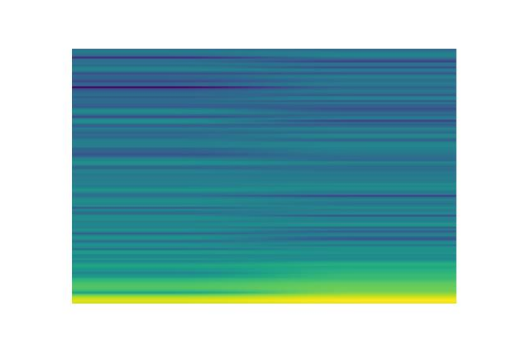

In [9]:
image = x_train[10]
plt.axis('off')
plt.imshow(image)

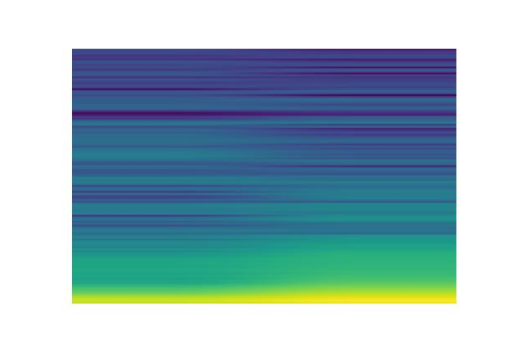

In [10]:
image = x_train[100]
plt.axis('off')
plt.imshow(image)

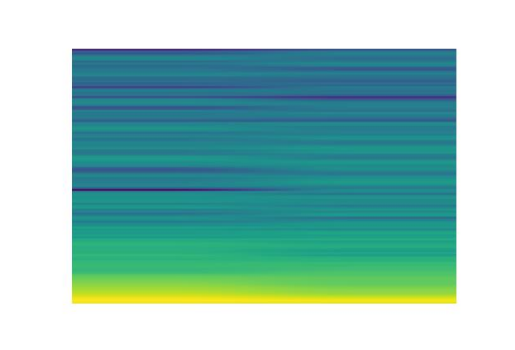

In [11]:
image = x_train[300]
plt.axis('off')
plt.imshow(image)

# Data Loader

In [12]:
# data loader 
class HI_dataset_train(torch.utils.data.Dataset):
    def __init__(self, x_path, y, transform=None, target_transform=None):
        
        self.y = y
        self.x_path = x_path
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        #print("idx=",idx)

        filename = f'{idx}.jpg'
        spectra = cv2.imread(os.path.join(self.x_path,filename))
        spectra = cv2.cvtColor(spectra, cv2.COLOR_BGR2RGB)
        label = self.y[idx,:].reshape(1, -1)
        #label = label.view(1, -1)
        #print(spectra.shape)
        if self.transform:
            spectra = self.transform(spectra)
            spectra = spectra.view(3,spectra.shape[0], spectra.shape[1])
        if self.target_transform:
            label = self.target_transform(label)
        return spectra, label

In [13]:
# data loader 
class HI_dataset_validate(torch.utils.data.Dataset):
    def __init__(self, x_path, y, transform=None, target_transform=None):
        
        self.y = y
        self.x_path = x_path
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        name = idx+32781

        filename = f'{name}.jpg'
        spectra = cv2.imread(os.path.join(self.x_path,filename))
        spectra = cv2.cvtColor(spectra, cv2.COLOR_BGR2RGB)
        label = self.y[idx,:].reshape(1, -1)
        #label = label.view(1, -1)
        #print(spectra.shape)
        if self.transform:
            spectra = self.transform(spectra)
            spectra = spectra.view(3,spectra.shape[0], spectra.shape[1])
        if self.target_transform:
            label = self.target_transform(label)
        return spectra, label

In [14]:
# transform to tenor 
class ToTensor_x():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [15]:
# transform to tenor 
class ToTensor_y():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        x =x.squeeze()
        return x

In [16]:
# initialize dataset
train_path = os.path.join(os.getcwd(),"data", "curve", "images", "x_train")
validate_path = os.path.join(os.getcwd(),"data", "curve", "images", "x_validate")
test_path = os.path.join(os.getcwd(),"data","curve", "images", "x_test")
#print(data['Y_train'].shape)
#print(data['Y_train'].shape[0]-6000)
dataset_train = HI_dataset_train(x_path = train_path, y=(data['Y_train'])[0:data['Y_train'].shape[0]-6000, :], transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_test = HI_dataset_train(x_path =test_path, y=data['Y_test'], transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_validate = HI_dataset_validate(x_path =validate_path, y=(data['Y_train'])[data['Y_train'].shape[0]-6000:data['Y_train'].shape[0], :], transform=ToTensor_x(), target_transform=ToTensor_y())

In [18]:
# initialize data loader
batch_size =16 #20
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =True)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_validate, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [19]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([16, 3, 400, 600])
torch.Size([16, 2])


# CNN

In [29]:
#from torchvision.models import densenet121, DenseNet121_Weights
#model = densenet121(pretrained = True)
#model.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)
# https://pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html#torchvision.models.densenet121

from torchvision.models import mnasnet0_5
model = mnasnet0_5(pretrained=True)
model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)

#model.fc = nn.Linear(in_features = 1024, out_features=2)

#model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

C:\Users\Administrator\.conda\envs\torch1.12.1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MNASNet0_5_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# number of parameter
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    #print(table)
    #print(f"Total Trainable Params: {total_params}")
    return total_params
print("number of parameter:", count_parameters(model))

number of parameter: 940074


##  Training setting

In [31]:
# training setting

lr = 0.005
#lr = 0.0005
num_epoch = 80
num_step = len(X_train)/batch_size
print(len(X_train), batch_size, num_step)
loss_function = nn.MSELoss()
best_err = 100000
optimizer = torch.optim.SGD(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones = [num_epoch*0.8], gamma=0.1, last_epoch=-1, verbose=False)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )
model.to(device)

38781 16 2423.8125


MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(8, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(24, 24,

In [23]:
training_MES = []
vaidation_MSE = []
testing_MSE = []

In [24]:
# train 
def train(epoch):
    global training_MES
    print('\nEpoch: %d' % epoch)
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward 
        outputs = model(inputs)
        #print("output = ", outputs)
        #target.view(1, -1)
        #outputs = outputs.view(outputs[0], 1, outputs[1])
        #print("otput shape=",outputs.shape)
       # print("values shape = ", values.shape)
        loss = loss_function(outputs, values)
        #print("loss = ", loss)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
        if (index+1)%1000==0:
            print(f'epoch: {epoch+1}/{num_epoch}, step: {index+1}/{num_step}, avg_loss = {train_loss/total}')
            #print(f'truth = {values}, preditction = {outputs}, error = {loss.item()}')
            #print("outputs = ", outputs)
            #print(model.conv1.weight.grad) 
    training_MES.append(train_loss/total)
    print("total loss = ", train_loss)
    print("total = ",total)

In [28]:
def validation(epoch):
    global best_err
    global vaidation_MSE
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float() 
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    vaidation_MSE.append(test_loss/total)
    # Save checkpoint.
    error =  test_loss / total
    print('avg_validate_accuracy=', error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_Spectragram.pth')
        best_err = error

In [26]:
def test(epoch):
    global best_err
    global testing_MSE
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        testing_MSE.append(test_loss/total)
        print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')

## Start Training

In [27]:
# start training
for epoch in range(num_epoch):
    train(epoch)
    validation(epoch)
    scheduler.step()
    test(epoch)


Epoch: 0
epoch: 1/80, step: 1000/2423.8125, avg_loss = 0.02482868378679268
epoch: 1/80, step: 2000/2423.8125, avg_loss = 0.01915789641113952
total loss =  623.8877116017975
total =  32781
avg_validate_accuracy= 0.010077204177776973
best_err: 0.010077204177776973 Saving..
Test performance in epoch 0: avg_error = 0.013970641162374923

Epoch: 1
epoch: 2/80, step: 1000/2423.8125, avg_loss = 0.011146495527471417
epoch: 2/80, step: 2000/2423.8125, avg_loss = 0.010614426447020379
total loss =  346.5828063678928
total =  32781
avg_validate_accuracy= 0.009018182856341202
best_err: 0.009018182856341202 Saving..
Test performance in epoch 1: avg_error = 0.01132165462356703

Epoch: 2
epoch: 3/80, step: 1000/2423.8125, avg_loss = 0.009549742877250538
epoch: 3/80, step: 2000/2423.8125, avg_loss = 0.009619075276132207
total loss =  314.4584618033841
total =  32781
avg_validate_accuracy= 0.01121664176384608
Test performance in epoch 2: avg_error = 0.01656528000302356

Epoch: 3
epoch: 4/80, step: 1000/

KeyboardInterrupt: 

## Plot training process

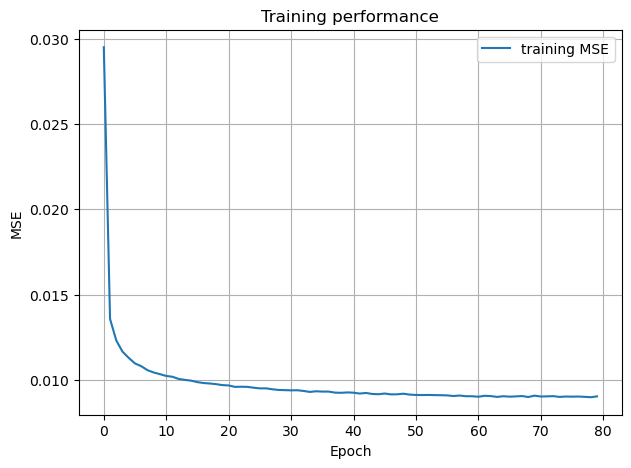

In [42]:
x = training_MES
plt.figure(figsize=(7,5))
plt.title('Training performance')
plt.plot(x, label='training MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\spectragram_training.jpg")
plt.show()

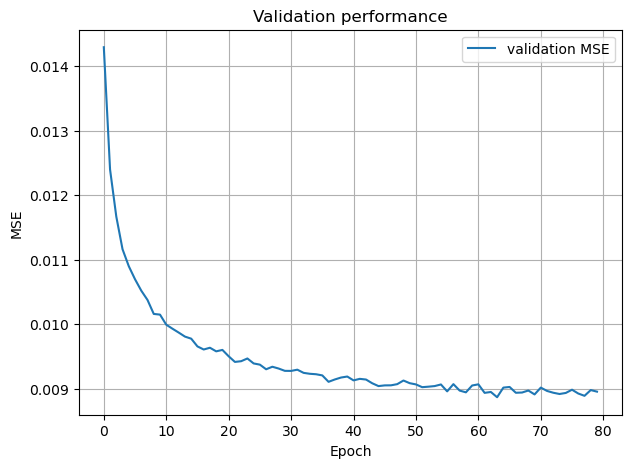

In [43]:
x = vaidation_MSE
plt.figure(figsize=(7,5))
plt.title('Validation performance')
plt.plot(x, label='validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\spectragram_validation.jpg")
plt.show()

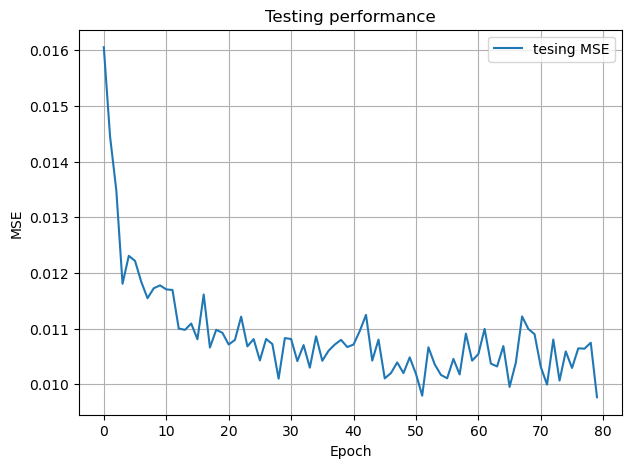

In [44]:
x = testing_MSE
plt.figure(figsize=(7,5))
plt.title('Testing performance')
plt.plot(x, label='tesing MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\spectragram_testing.jpg")
plt.show()

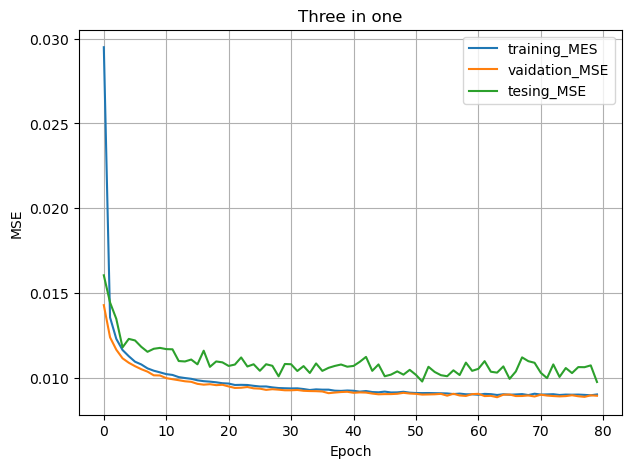

In [45]:
x1 = training_MES
x2 = vaidation_MSE
x3 = testing_MSE
plt.figure(figsize=(7,5))
plt.title('Three in one')
plt.plot(x1, label='training_MES')
plt.plot(x2, label='vaidation_MSE')
plt.plot(x3, label='tesing_MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.savefig(os.path.join(os.getcwd(),"training_process")+"\\spectragram_3in1.jpg")
plt.show()

## Save into excel

In [46]:
x1 = np.array(training_MES).reshape(1, -1)
x2 = np.array(vaidation_MSE).reshape(1, -1)
x3 = np.array(testing_MSE).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_excel(excel_writer = os.path.join(os.getcwd(),"training_process") + "\\spectragram.xlsx")

## Model testing

In [51]:
# model testing

model = mnasnet0_5(pretrained=False)
model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
model.to(device)
checkpoint = torch.load('./checkpoint/ckpt_Spectragram.pth')
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
#loss = checkpoint['loss']

test(epoch)

Test performance in epoch 63: avg_error = 0.010446095574197584
